## Multivariate Student-t Distribution
### Gamma Function
### Gamma Distribution 
### Derivation for the Student-t Distribution using Gamma conjugate prior for the Gaussian with an unknown precision matrix
### Effect of the degrees of freedom on the Mahalanobis Distance 
### Assuming the degrees of freedom to be known in advance
#### Assumption about the Latent Variable and its conditional Distribution
#### E-step 
#### M-step
#### Convergence Test

### Assuming the degrees of freedom to be unknown in advance
#### Assumption about the Latent Variable and its conditional Distribution
#### Multicycle ECM
##### E-step
##### First CM 
##### Second CM-step
#### Convergence Test

------------------------
I only implemented the model with the Assumption that the degree of freedom is known.


In [2]:
%matplotlib inline
import numpy as np 
import sklearn.preprocessing
import sklearn.datasets
import pandas as pd
import sklearn.model_selection
import numpy.random
import math
import sklearn.metrics
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt

In [3]:
class MultiVariateSt_t_knownDF_Model(object):

    def __init__(self, X_train, df):
        self.m = X_train.shape[0]
        self.n = X_train.shape[1]
        if df > 0:
            self.df = df
        else: 
            print("Wrong df value because if you view gamma function as a factorial, negative value of n wouldn't exist")
            raise Exception("wrong df")
        self.X_train = X_train
        self.mean  = np.random.randn(self.n)
        self.covariance = np.eye(self.n)#Create a full rank covariance matrix
        self.latent_u_soft = np.zeros((self.m, 1))
    
    def Mahalanobis_distance(self, x):
        return np.dot(np.transpose(x.reshape(-1, 1) - self.mean.reshape(-1, 1)), np.dot(np.linalg.inv(self.covariance), x.reshape(-1, 1) - self.mean.reshape(-1, 1)))
    
    def E_step(self):
        for i in range(0, self.m):
            self.latent_u_soft[i, 0] = (self.df + self.n)/(self.df + self.Mahalanobis_distance(self.X_train[i, :]))
    
    def M_step(self):
        self.mean = np.sum(self.latent_u_soft.reshape(-1, 1) * self.X_train, axis=0)#using broadcasting
        self.mean = self.mean/np.sum(self.latent_u_soft)
        for i in range(0, self.m):
            self.covariance += self.latent_u_soft[i, 0] * np.dot((self.X_train[i, :].reshape(-1, 1) - self.mean.reshape(-1, 1)),(self.X_train[i, :].reshape(-1, 1) - self.mean.reshape(-1, 1)).T)
        self.covariance /= self.m

    def computing_log_likelihood(self):
        #I know you can use pdf method from stats package but I really want to implement everything from scratch
        det = np.linalg.det(self.covariance)
        temp = 0
        for i in range(0, self.m):
            #print((1/(1 + (self.Mahalanobis_distance(self.X_train[i, :])/ self.df) )**((self.df+self.n)/2) ))
            temp += np.log(
                (scipy.special.gamma((self.df + self.n)/2)/scipy.special.gamma(self.df /2) ) * (1/(np.pi * self.df)) * 
                (1/np.sqrt(det)) * 
                (1/(1 + (self.Mahalanobis_distance(self.X_train[i, :])/ self.df) )**((self.df+self.n)/2) )

            )
            #print(temp.shape)
        #print(temp)
        return temp

    def fit(self, max_iteration, eps=1e-5):
        convergence_test = True
        count = 0
        while( (convergence_test == True) and (count != max_iteration)):
            self.E_step()#Update the soft latent values            
            log_likelihood_t = self.computing_log_likelihood()
            self.M_step()#Update the parameters of the condtional distribution of x given u
            log_likelihood_t_future = self.computing_log_likelihood()
            print(f"Number of iteration:{count}, max_iteration:{max_iteration}, past:{log_likelihood_t}, future:{log_likelihood_t_future}")
            count = count + 1
            if( (log_likelihood_t_future - log_likelihood_t) < eps and (count > 10)):
                print("We converged to the optimal value for the log-likelihood")
                convergence_test =False #We reached the parameters that maximize the log-likelihood, no adancement in the log-likelihood
        
        return self.mean, self.covariance

    

In [4]:
scipy.special.gamma((4+ 10)/2)

720.0

In [5]:
#Generating random variables from multivariate Student-t distribution 
###https://stackoverflow.com/questions/29798795/multivariate-student-t-distribution-with-python##
def multivariatet(mu,Sigma,dof,m):
    '''
    Output:
    Produce M samples of d-dimensional multivariate t distribution
    Input:
    mu = mean (d dimensional numpy array or scalar)
    Sigma = scale matrix (dxd numpy array)
    dof = degrees of freedom
    m = # of samples to produce
    '''
    d = Sigma.shape[1]
    g = np.tile(np.random.gamma(dof/2.,2./dof,m),(d,1)).T#From https://en.wikipedia.org/wiki/Multivariate_t-distribution, and the relationship between gamma distribution and chi-squared distribution
    #Page 4 from http://users.isy.liu.se/en/rt/roth/student.pdf
    Z = np.random.multivariate_normal(np.zeros(d),Sigma,m)
    return mu + Z/np.sqrt(g[:])

In [6]:
numpy.random.seed(42)

n = 10
df = 20.5
m = 600
mean = np.random.randn(n).reshape(-1, 1)
Sigma = np.random.randn(n, n) 
Sigma = np.dot(Sigma, Sigma.T)
print(np.linalg.matrix_rank(Sigma))#Need to ensure that the cov is full rank, otherwise the inverse of the covariance wouldn't exist
X_train = multivariatet(mean.reshape(1, -1),Sigma,df,m)
print(X_train.shape)
#Check its mean 
c1 = np.mean(X_train, axis=0)
c2 = (df/(df-2)) * np.cov(X_train.T)
print("Comparing Means")
[print(f"x1:{x1}|x2:{x2}") for x1, x2 in  zip(mean, c1)];
print("Comparing Covariance")
[print(f"new row\n x1:{x1}\nx2:{x2}") for x1, x2 in  zip(Sigma, c2)];
# I am going to assume the mean and covariance that would be estimated will have the following form
mean = c1
cov = c2


10
(600, 10)
Comparing Means
x1:[0.49671415]|x2:0.49653380732299374
x1:[-0.1382643]|x2:-0.16462616398202418
x1:[0.64768854]|x2:1.0233054732627251
x1:[1.52302986]|x2:1.5165451451986076
x1:[-0.23415337]|x2:-0.33881044510445035
x1:[-0.23413696]|x2:-0.3567652317993122
x1:[1.57921282]|x2:1.668998442496496
x1:[0.76743473]|x2:0.8675994665383748
x1:[-0.46947439]|x2:-0.3331226030370452
x1:[0.54256004]|x2:0.47848832942143277
Comparing Covariance
new row
 x1:[11.38604372  5.28604885  0.8048872   6.05785339 -4.53272108  1.1363972
  2.71224636  1.89369635  1.56897668  0.37063511]
x2:[14.31431566  6.77180587  1.03502265  7.15230015 -5.52231816  1.87319955
  2.55361653  2.50897782  1.54856918  0.55062332]
new row
 x1:[ 5.28604885  6.45401237 -0.61353727  3.42509235 -0.44698516  1.10818662
 -0.21978486  0.05845521  0.21673388 -2.96532357]
x2:[ 6.77180587  7.98633567 -0.39184603  4.12958504 -0.66492877  0.87300653
 -0.48378503  0.48960353  0.3046924  -4.07079212]
new row
 x1:[ 8.04887205e-01 -6.1353726

In [7]:
model = MultiVariateSt_t_knownDF_Model(X_train, df)
estimated_mean, estimated_cov = model.fit(1000)

Number of iteration:0, max_iteration:1000, past:[[-11346.45578732]], future:[[-3558.70662448]]
Number of iteration:1, max_iteration:1000, past:[[-3558.70662448]], future:[[-2124.6794185]]
Number of iteration:2, max_iteration:1000, past:[[-2124.6794185]], future:[[-1750.19207989]]
Number of iteration:3, max_iteration:1000, past:[[-1750.19207989]], future:[[-1678.00709337]]
Number of iteration:4, max_iteration:1000, past:[[-1678.00709337]], future:[[-1666.80999937]]
Number of iteration:5, max_iteration:1000, past:[[-1666.80999937]], future:[[-1665.29122733]]
Number of iteration:6, max_iteration:1000, past:[[-1665.29122733]], future:[[-1665.11497534]]
Number of iteration:7, max_iteration:1000, past:[[-1665.11497534]], future:[[-1665.10331835]]
Number of iteration:8, max_iteration:1000, past:[[-1665.10331835]], future:[[-1665.10626226]]
Number of iteration:9, max_iteration:1000, past:[[-1665.10626226]], future:[[-1665.10831806]]
Number of iteration:10, max_iteration:1000, past:[[-1665.1083

In [8]:
print("Comparing Means")
[print(f"True x1:{x1}|Est. x2:{x2}") for x1, x2 in  zip(mean, estimated_mean)];
print("Comparing Covariance")
[print(f"new row\n True x1:{x1}\nEst. x2:{x2}") for x1, x2 in  zip(cov, estimated_cov)];

Comparing Means
True x1:0.49653380732299374|Est. x2:0.5173505399135495
True x1:-0.16462616398202418|Est. x2:-0.16366947059216902
True x1:1.0233054732627251|Est. x2:0.9652963806413932
True x1:1.5165451451986076|Est. x2:1.5389171681157439
True x1:-0.33881044510445035|Est. x2:-0.32405819258265267
True x1:-0.3567652317993122|Est. x2:-0.32069734485236656
True x1:1.668998442496496|Est. x2:1.6960931674805255
True x1:0.8675994665383748|Est. x2:0.8313201405070806
True x1:-0.3331226030370452|Est. x2:-0.3510018619545503
True x1:0.47848832942143277|Est. x2:0.4742485980072653
Comparing Covariance
new row
 True x1:[14.31431566  6.77180587  1.03502265  7.15230015 -5.52231816  1.87319955
  2.55361653  2.50897782  1.54856918  0.55062332]
Est. x2:[11.69355181  5.55929965  0.7440489   5.98773359 -4.51021988  1.46369112
  2.26488902  2.01630838  1.37582206  0.34504247]
new row
 True x1:[ 6.77180587  7.98633567 -0.39184603  4.12958504 -0.66492877  0.87300653
 -0.48378503  0.48960353  0.3046924  -4.07079212

In [9]:
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([1, 2])
b.reshape(-1, 1) *a

array([[ 1,  2,  3],
       [ 8, 10, 12]])

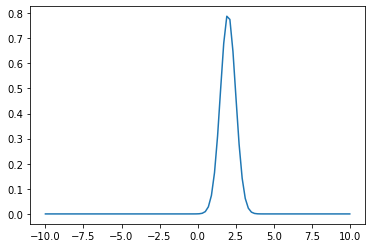

A normal continuous random variable.

    The location (``loc``) keyword specifies the mean.
    The scale (``scale``) keyword specifies the standard deviation.

    As an instance of the `rv_continuous` class, `norm` object inherits from it
    a collection of generic methods (see below for the full list),
    and completes them with details specific for this particular distribution.
    
    Methods
    -------
    rvs(loc=0, scale=1, size=1, random_state=None)
        Random variates.
    pdf(x, loc=0, scale=1)
        Probability density function.
    logpdf(x, loc=0, scale=1)
        Log of the probability density function.
    cdf(x, loc=0, scale=1)
        Cumulative distribution function.
    logcdf(x, loc=0, scale=1)
        Log of the cumulative distribution function.
    sf(x, loc=0, scale=1)
        Survival function  (also defined as ``1 - cdf``, but `sf` is sometimes more accurate).
    logsf(x, loc=0, scale=1)
        Log of the survival function.
    ppf(q, loc=0, scale

In [29]:
x = np.linspace(-10, 10, 100)
rv = scipy.stats.norm.pdf(x, loc=2, scale=0.5)
plt.plot(x, rv)
plt.show()
print(scipy.stats.norm.__doc__)

### References 
* Chapter 2, Chapter 9 and Chapter 12 from Bishop, C. (2006). Pattern Recognition and Machine Learning. Cambridge: Springer.
* Chapter 5 from McNicholas, P.D. (2016). Mixture Model-Based Classification. Boca Raton: Chapman &
Hall/CRC Press.
* McLachlan, G., and  Krishnan T. (2008). The EM Algorithm and Extensions, Second Edition. New York: Wiley.